# Temporary inspection: penultimate quick run

This notebook inspects metrics and embeddings from:
`trustME/data/processed/imwut_tobii_finetuned_penultimate_quick/`

In [1]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
ROOT = Path('.')
RUN_DIR = ROOT / 'trustME' / 'data' / 'processed' / 'imwut_tobii_finetuned_penultimate_quick'
MANIFEST_PATH = RUN_DIR / 'run_manifest.json'

assert RUN_DIR.exists(), f'Missing run directory: {RUN_DIR}'
assert MANIFEST_PATH.exists(), f'Missing manifest: {MANIFEST_PATH}'

print('RUN_DIR:', RUN_DIR)
print('MANIFEST_PATH:', MANIFEST_PATH)

RUN_DIR: trustME/data/processed/imwut_tobii_finetuned_penultimate_quick
MANIFEST_PATH: trustME/data/processed/imwut_tobii_finetuned_penultimate_quick/run_manifest.json


In [3]:
with MANIFEST_PATH.open('r', encoding='utf-8') as f:
    manifest = json.load(f)

manifest.keys()

dict_keys(['config', 'config_path', 'generated_at_utc', 'input_dir', 'out_dir', 'pipeline_version', 'schemes'])

In [4]:
rows = []
for scheme, payload in manifest['schemes'].items():
    rows.append({
        'scheme': scheme,
        'n_samples': payload.get('n_samples'),
        'head_type': payload.get('head_type'),
        'encoder_tune_scope': payload.get('encoder_tune_scope'),
        'unfreeze_last_n_blocks': payload.get('unfreeze_last_n_blocks'),
        'trainable_parameter_count': payload.get('trainable_parameter_count'),
        'val_balanced_accuracy': payload.get('metrics_summary', {}).get('val_balanced_accuracy'),
        'test_balanced_accuracy': payload.get('metrics_summary', {}).get('test_balanced_accuracy'),
    })

summary_df = pd.DataFrame(rows).sort_values('scheme').reset_index(drop=True)
summary_df

,scheme,n_samples,head_type,encoder_tune_scope,unfreeze_last_n_blocks,trainable_parameter_count,val_balanced_accuracy,test_balanced_accuracy
0,avm,770,mlp,last_n_blocks,1,13,0.547831,0.512545


## Load metrics files

In [5]:
def load_scheme_metrics(run_dir: Path) -> dict:
    out = {}
    for scheme_dir in sorted(run_dir.iterdir()):
        if not scheme_dir.is_dir():
            continue
        metrics_path = scheme_dir / 'metrics.json'
        if metrics_path.exists():
            with metrics_path.open('r', encoding='utf-8') as f:
                out[scheme_dir.name] = json.load(f)
    return out

metrics_by_scheme = load_scheme_metrics(RUN_DIR)
list(metrics_by_scheme.keys())

['avm']

In [6]:
metric_rows = []
for scheme, m in metrics_by_scheme.items():
    metric_rows.append({
        'scheme': scheme,
        'best_epoch': m.get('best_epoch'),
        'train_bal_acc': m.get('train', {}).get('balanced_accuracy'),
        'val_bal_acc': m.get('val', {}).get('balanced_accuracy'),
        'test_bal_acc': m.get('test', {}).get('balanced_accuracy'),
        'train_macro_f1': m.get('train', {}).get('macro_f1'),
        'val_macro_f1': m.get('val', {}).get('macro_f1'),
        'test_macro_f1': m.get('test', {}).get('macro_f1'),
    })

pd.DataFrame(metric_rows).sort_values('scheme').reset_index(drop=True)

,scheme,best_epoch,train_bal_acc,val_bal_acc,test_bal_acc,train_macro_f1,val_macro_f1,test_macro_f1
0,avm,13,0.653706,0.547831,0.512545,0.64155,0.505676,0.50991


## Confusion matrices (row-normalized, fixed color scale [0,1])

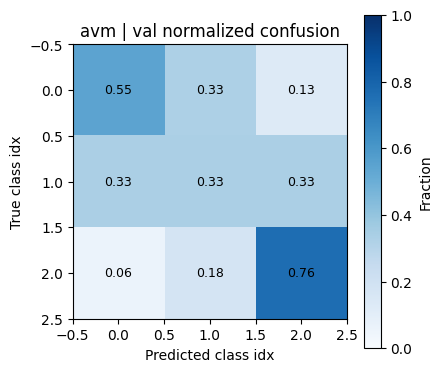

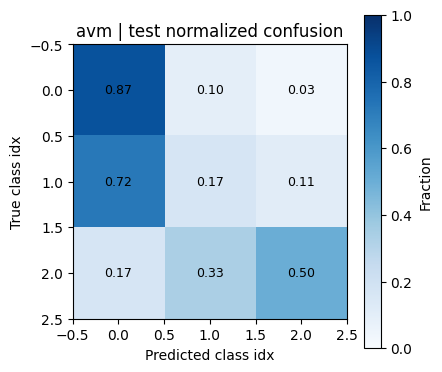

In [7]:
def plot_confusion_normalized(metrics: dict, split: str, scheme: str) -> None:
    conf_norm = np.asarray(metrics[split]['confusion_matrix_normalized'], dtype=float)
    fig, ax = plt.subplots(figsize=(4.5, 4.0))
    im = ax.imshow(conf_norm, cmap='Blues', vmin=0.0, vmax=1.0)
    ax.set_title(f'{scheme} | {split} normalized confusion')
    ax.set_xlabel('Predicted class idx')
    ax.set_ylabel('True class idx')
    for i in range(conf_norm.shape[0]):
        for j in range(conf_norm.shape[1]):
            ax.text(j, i, f'{conf_norm[i, j]:.2f}', ha='center', va='center', fontsize=9)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Fraction')
    plt.tight_layout()
    plt.show()

for scheme, metrics in sorted(metrics_by_scheme.items()):
    for split in ('val', 'test'):
        plot_confusion_normalized(metrics, split=split, scheme=scheme)

## Embeddings inspection

In [8]:
def load_scheme_embeddings(run_dir: Path, scheme: str) -> dict:
    p = run_dir / scheme / 'embeddings.npz'
    assert p.exists(), f'Missing embeddings: {p}'
    payload = np.load(p, allow_pickle=False)
    return {
        'path': p,
        'embeddings': payload['embeddings'],
        'segment_id': payload['segment_id'].astype(str),
        'label_int': payload['label_int'].astype(int),
        'label_str': payload['label_str'].astype(str),
        'split': payload['split'].astype(str),
    }

embeds = {scheme: load_scheme_embeddings(RUN_DIR, scheme) for scheme in sorted(metrics_by_scheme.keys())}
list(embeds.keys())

['avm']

In [9]:
rows = []
for scheme, d in embeds.items():
    rows.append({
        'scheme': scheme,
        'n_samples': d['embeddings'].shape[0],
        'embedding_dim': d['embeddings'].shape[1],
        'n_classes': len(np.unique(d['label_str'])),
        'splits': dict(pd.Series(d['split']).value_counts()),
        'labels': dict(pd.Series(d['label_str']).value_counts()),
    })

pd.DataFrame(rows)

,scheme,n_samples,embedding_dim,n_classes,splits,labels
0,avm,770,1024,3,"{'train': 619, 'val': 84, 'test': 67}","{'attention_task': 428, 'memory_task': 202, 'v..."


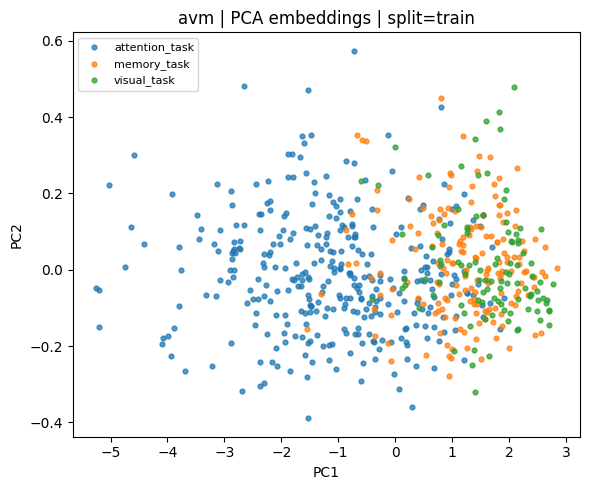

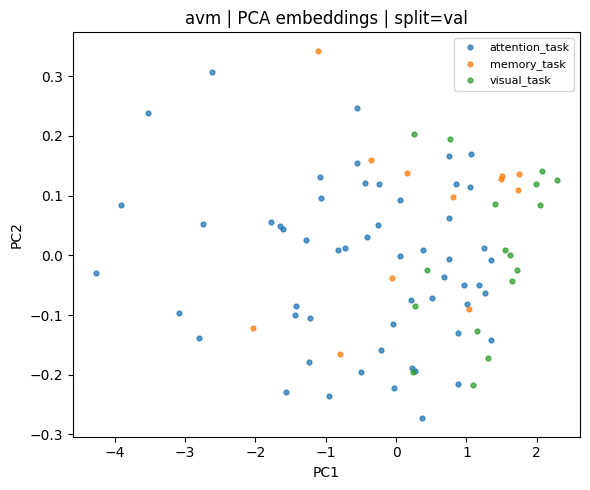

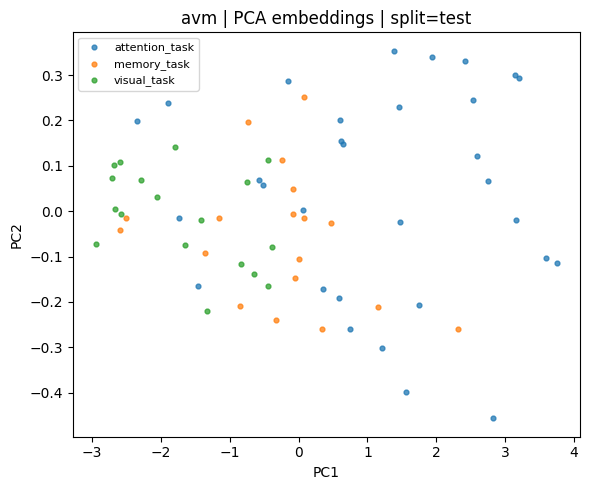

In [10]:
def pca_plot_embeddings_by_label(d: dict, scheme: str, split_filter: str | None = None) -> None:
    X = d['embeddings']
    y = d['label_str']
    split = d['split']

    mask = np.ones(X.shape[0], dtype=bool)
    if split_filter is not None:
        mask = split == split_filter

    X_use = X[mask]
    y_use = y[mask]
    if X_use.shape[0] < 3:
        print(f'Skip {scheme} ({split_filter}): too few samples')
        return

    pca = PCA(n_components=2, random_state=42)
    Z = pca.fit_transform(X_use)

    fig, ax = plt.subplots(figsize=(6, 5))
    labels = sorted(np.unique(y_use))
    for label in labels:
        idx = y_use == label
        ax.scatter(Z[idx, 0], Z[idx, 1], s=12, alpha=0.75, label=label)

    tag = split_filter if split_filter is not None else 'all'
    ax.set_title(f'{scheme} | PCA embeddings | split={tag}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.legend(loc='best', fontsize=8)
    plt.tight_layout()
    plt.show()

for scheme, d in embeds.items():
    pca_plot_embeddings_by_label(d, scheme=scheme, split_filter='train')
    pca_plot_embeddings_by_label(d, scheme=scheme, split_filter='val')
    pca_plot_embeddings_by_label(d, scheme=scheme, split_filter='test')